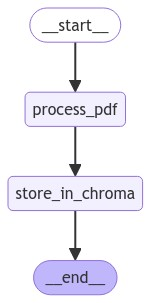

Initial state:------------------------------------------------------------------
Current file: data\STA14_STL_ETI_Risk_Assessment_Methodology_01552_13_01824.V5.1_JUNE_2023-1-5.pdf
Processed files: []
Number of chunks: 0
State after process_pdf:--------------------------------------------------------
Current file: 
Processed files: ['data\\STA14_STL_ETI_Risk_Assessment_Methodology_01552_13_01824.V5.1_JUNE_2023-1-5.pdf']
Number of chunks: 31
State after store_in_chroma:----------------------------------------------------
Current file: 
Processed files: ['data\\STA14_STL_ETI_Risk_Assessment_Methodology_01552_13_01824.V5.1_JUNE_2023-1-5.pdf']
Number of chunks: 0


In [2]:
from typing import Dict, TypedDict, List
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import OllamaEmbeddings
import fitz  # PyMuPDF
import re
import os

class AgentState(TypedDict):
    messages: List[BaseMessage]
    current_file: str
    processed_files: List[str]
    chunks: List[Dict]

initial_state = AgentState(
    messages=[HumanMessage(content="Let's process some PDF files.")],
    current_file="",
    processed_files=[],
    chunks=[]
)

def process_pdf(state: AgentState) -> AgentState:
    if not state["current_file"]:
        return state

    # Create a directory for saving images
    pdf_name = os.path.splitext(os.path.basename(state["current_file"]))[0]
    image_dir = f"images_{pdf_name}"
    os.makedirs(image_dir, exist_ok=True)

    doc = fitz.open(state["current_file"])
    chunks = []
    toc = []
    current_section = ""

    def add_chunk(content: str, chunk_type: str, metadata: Dict):
        chunks.append({
            "text": content,
            "type": chunk_type,
            "metadata": {**metadata, "section": current_section}
        })

    # Extract table of contents
    for i in doc.get_toc():
        toc.append(f"{'  ' * (i[0] - 1)}{i[1]}")
    
    if toc:
        add_chunk("\n".join(toc), "table_of_contents", {"page": 0})
    # print(toc)
    for page_num, page in enumerate(doc):
        text = page.get_text()
        
        # Check for new section
        section_match = re.match(r'^\d+\s+(.+)$', text.strip().split('\n')[0])
        if section_match:
            current_section = section_match.group(1)

        # Process tables
        tables = page.find_tables()
        for table in tables:
            table_text = "\n".join([" | ".join(str(cell) if cell is not None else "" for cell in row) for row in table.extract()])
            add_chunk(table_text, "table", {"page": page_num + 1})

        # Process images
        images = page.get_images(full=True)
        for img_index, img in enumerate(images):
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes = base_image["image"]
            image_ext = base_image["ext"]
            
            # Save image to file
            image_filename = f"{pdf_name}_page{page_num+1}_img{img_index+1}.{image_ext}"
            image_path = os.path.join(image_dir, image_filename)
            with open(image_path, "wb") as image_file:
                image_file.write(image_bytes)
            
            # Find image caption
            caption = ""
            caption_match = re.search(r'Figure \d+\s*:\s*(.+)', text)
            if caption_match:
                caption = caption_match.group(1)

            add_chunk(f"Image: {caption}", "image", {
                "page": page_num + 1,
                "image_index": img_index,
                "image_path": image_path
            })

        # Process text (excluding tables and image captions)
        text_chunks = text.split('\n\n')
        for chunk in text_chunks:
            if not any(chunk.startswith(f"{i}") for i in range(1, 10)) and "Figure" not in chunk:
                add_chunk(chunk, "text", {"page": page_num + 1})

    state["chunks"].extend(chunks)
    state["processed_files"].append(state["current_file"])
    state["current_file"] = ""
    
    doc.close()
    print("State after process_pdf:--------------------------------------------------------")
    print(f"Current file: {state['current_file']}")
    print(f"Processed files: {state['processed_files']}")
    print(f"Number of chunks: {len(state['chunks'])}")
    return state

def store_in_chroma(state: AgentState) -> AgentState:
    # Use OllamaEmbeddings with the mxbai model
    embeddings = OllamaEmbeddings(model="nomic-embed-text")
    
    texts = [chunk["text"] for chunk in state["chunks"]]
    metadatas = [chunk["metadata"] for chunk in state["chunks"]]
    
    vectorstore = Chroma.from_texts(
        texts=texts,
        metadatas=metadatas,
        embedding=embeddings
    )
    
    # Clear the chunks after storing
    state["chunks"] = []
    
    print("State after store_in_chroma:----------------------------------------------------")
    print(f"Current file: {state['current_file']}")
    print(f"Processed files: {state['processed_files']}")
    print(f"Number of chunks: {len(state['chunks'])}")
    return state

workflow = StateGraph(AgentState)

workflow.add_node("process_pdf", process_pdf)
workflow.add_node("store_in_chroma", store_in_chroma)

workflow.add_edge("process_pdf", "store_in_chroma")
workflow.add_edge("store_in_chroma", END)

workflow.set_entry_point("process_pdf")
app =workflow.compile()
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))
def run_workflow(file_path: str):
    app = workflow.compile()
    
    state = initial_state.copy()
    state["current_file"] = file_path
    
    print("Initial state:------------------------------------------------------------------")  
    print(f"Current file: {state['current_file']}")
    print(f"Processed files: {state['processed_files']}")
    print(f"Number of chunks: {len(state['chunks'])}")
    
    for output in app.stream(state):
        if output.get("type") == "end":
            print("Workflow completed.")
            break
        # else:
        #     print(f"Current step: {output}")

# Example usage
run_workflow("data\STA14_STL_ETI_Risk_Assessment_Methodology_01552_13_01824.V5.1_JUNE_2023-1-5.pdf")

In [22]:
import asyncio
from functools import lru_cache
import os
from typing import Dict, Any, TypedDict, List
from typing import List, Dict, Any
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

from langchain_nvidia_ai_endpoints import ChatNVIDIA
import pandas as pd
from dotenv import load_dotenv
load_dotenv()

# Load the Nvidia API key
os.environ['NVIDIA_API_KEY'] = os.getenv("NVIDIA_API_KEY")
llm = ChatNVIDIA(model="meta/llama-3.1-405b-instruct")
class DataState(TypedDict):
    df: pd.DataFrame
def load_data(file_path: str) -> Dict[str, Any]:
    """This tool loads data from an Excel file."""
    try:
        print("initializint data State")
        # s = DataState()
        print(f"Attempting to load file from: {file_path}")
        df = pd.read_excel(file_path, nrows=2)
        print(df)
        return {"data": df}
    except Exception as e:
        return {"error": f"Error loading file: {str(e)}"}
@lru_cache(maxsize=128)
def get_llm_response(context: str) -> str:
    # This function can be memoized to avoid redundant API calls
    prompt = ChatPromptTemplate.from_messages([
            ("system", "You are an AI consultant assistant analyzing a conformity matrix, identify rows to update."),
            ("human", "{input}")
        ])

    chain = prompt | llm | StrOutputParser()
    return chain.invoke({"input": context})

async def analyze_row(row: pd.Series) -> Dict[str, Any]:
    context = f"""
        Analyze this row from a conformity matrix:
        Supplier Status: {row['Status SUPPLIER XYZ']}
        Stakeholder Status: {row['Status Stakeholder']}
        Supplier Comments: {row['Comments SUPPLIER XYZ']}
        Stakeholder Comments: {row['Comments Stakeholder']}

        Determine which of the following cases applies and provide a brief explanation:

        1. Supplier - Requirement Accepted:
          Condition: Supplier accepts the requirement with no comments or conditions.

        2. Supplier - Requirement Accepted with Deviation:
          Condition: Supplier accepts the requirement with deviations.

        3. Supplier - Requirement Rejected / Not Applicable:
          Condition: Supplier rejects the requirement or marks it as not applicable.

        4. Supplier - No Status:
          Condition: Supplier has not provided a status for the requirement.

        5. Status Reset:
          Condition: Specification/package has been updated, impacting certain requirements.

        6. Supplier Changes Previously Accepted Status:
          Condition: Supplier changes the status of a previously accepted requirement.

        7. Supplier Requests Clarifications:
          Condition: Supplier asks for clarifications on requirements.

        8. Supplier Requests Expert Meeting:
          Condition: Supplier requests a meeting with experts.

        Analyze the matrix data provided and respond with:
        1. A concise chain of thoughts explaining your reasoning process.
        2. The most applicable case number(s). Consider that some rows might have two cases combined.
        3. A brief explanation of why this case (or cases) applies.
        4. A confidence score from 0 to 100 for your conclusion.

        Format your response as follows:
        Thought process: [Your chain of reasoning]
        Case(s): [Case number(s)]
        Explanation: [Brief explanation]
        Confidence: [Score from 0 to 100]

        Remember, it's possible for multiple cases to apply to a single row. If you identify such a situation, 
        include all relevant case numbers and explain the combination.
        Make sure to make your answer as short and concise as possible.
        """

        
    analysis = await asyncio.to_thread(get_llm_response, context)
    return {"row": row.name + 2, "analysis": analysis}

async def analyze_conformity_matrix(df: pd.DataFrame) -> Dict[str, Any]:
    """This tool identifies rows that require updates after analyzing matrix."""
    tasks = [analyze_row(row) for _, row in df.iterrows()]
    results = await asyncio.gather(*tasks)
    rows_to_update = [result for result in results if any(f"Case {i}" in result['analysis'] for i in range(1, 9))]
    return {"rows_to_update": rows_to_update}

# Usage
file_path = "exhibit_01_drones.xlsx"
df = load_data(file_path)
rows_to_update = asyncio.run(analyze_conformity_matrix(df))

initializint data State
Attempting to load file from: exhibit_01_drones.xlsx
        ID Original iD                                        Description  \
0  REQ_001      NAV_03   For each feature, the supplier must provide d...   
1  REQ_002     SENS_06  The supplier must send the interface needed fo...   

                               Comments SUPPLIER XYZ  \
0  [2024-05-29 SYS Drone A]:  Extrinsic calibrati...   
1  [2024-05-28 SYS Drone A] ; Comments on behalf ...   

                                Comments Stakeholder Status SUPPLIER XYZ     \
0  20/05/2024_RM: Already accepted in conformity ...           Rejected       
1  20/05/2024_RM: Already accepted in conformity ...           Rejected       

  Status Stakeholder  Next action responsible   Responsibility To Review  \
0        In Progress                      NaN       SYS_DRONES, PM, CAQE   
1        In Progress                      NaN  SYS_DRONES, SW_DRONES, PM   

                      Type                             

RuntimeError: asyncio.run() cannot be called from a running event loop

In [18]:
import os
from typing import Dict, Any, TypedDict, List, Literal
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import asyncio
from functools import lru_cache
import pandas as pd
from dotenv import load_dotenv
from langgraph.graph import Graph, StateGraph, END
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage, HumanMessage
from langchain.tools import tool
load_dotenv()

# Load the Nvidia API key
os.environ['NVIDIA_API_KEY'] = os.getenv("NVIDIA_API_KEY")
llm = ChatNVIDIA(model="meta/llama-3.1-405b-instruct")

    

@tool
def find_file(filename: str) -> Dict[str, Any]:
    """This tool finds the full path of a file given its name."""
    current_dir = os.getcwd()
    for root, dirs, files in os.walk(current_dir):
        if filename in files:
            return {"file_path": os.path.join(root, filename)}
    return {"error": f"File '{filename}' not found in the current directory or its subdirectories."}
@tool
def load_data(file_path: str) -> Dict[str, Any]:
    """This tool loads data from an Excel file."""
    try:
        print("initializint data State")
        # s = DataState()
        print(f"Attempting to load file from: {file_path}")
        df = pd.read_excel(file_path, nrows=2)
        print(df)
        return {"data": df}
    except Exception as e:
        return {"error": f"Error loading file: {str(e)}"}
@lru_cache(maxsize=128)
def get_llm_response(context: str) -> str:
    # This function can be memoized to avoid redundant API calls
    prompt = ChatPromptTemplate.from_messages([
            ("system", "You are an AI consultant assistant analyzing a conformity matrix, identify rows to update."),
            ("human", "{input}")
        ])

    chain = prompt | llm | StrOutputParser()
    return chain.invoke({"input": context})

async def analyze_row(row: pd.Series) -> Dict[str, Any]:
    context = f"""
        Analyze this row from a conformity matrix:
        Supplier Status: {row['Status SUPPLIER XYZ']}
        Stakeholder Status: {row['Status Stakeholder']}
        Supplier Comments: {row['Comments SUPPLIER XYZ']}
        Stakeholder Comments: {row['Comments Stakeholder']}

        Determine which of the following cases applies and provide a brief explanation:

        1. Supplier - Requirement Accepted:
          Condition: Supplier accepts the requirement with no comments or conditions.

        2. Supplier - Requirement Accepted with Deviation:
          Condition: Supplier accepts the requirement with deviations.

        3. Supplier - Requirement Rejected / Not Applicable:
          Condition: Supplier rejects the requirement or marks it as not applicable.

        4. Supplier - No Status:
          Condition: Supplier has not provided a status for the requirement.

        5. Status Reset:
          Condition: Specification/package has been updated, impacting certain requirements.

        6. Supplier Changes Previously Accepted Status:
          Condition: Supplier changes the status of a previously accepted requirement.

        7. Supplier Requests Clarifications:
          Condition: Supplier asks for clarifications on requirements.

        8. Supplier Requests Expert Meeting:
          Condition: Supplier requests a meeting with experts.

        Analyze the matrix data provided and respond with:
        1. A concise chain of thoughts explaining your reasoning process.
        2. The most applicable case number(s). Consider that some rows might have two cases combined.
        3. A brief explanation of why this case (or cases) applies.
        4. A confidence score from 0 to 100 for your conclusion.

        Format your response as follows:
        Thought process: [Your chain of reasoning]
        Case(s): [Case number(s)]
        Explanation: [Brief explanation]
        Confidence: [Score from 0 to 100]

        Remember, it's possible for multiple cases to apply to a single row. If you identify such a situation, 
        include all relevant case numbers and explain the combination.
        Make sure to make your answer as short and concise as possible.
        """

        
    analysis = await asyncio.to_thread(get_llm_response, context)
    return {"row": row.name + 2, "analysis": analysis}

async def analyze_conformity_matrix(df: pd.DataFrame) -> Dict[str, Any]:
    """This tool identifies rows that require updates after analyzing matrix."""
    tasks = [analyze_row(row) for _, row in df.iterrows()]
    results = await asyncio.gather(*tasks)
    rows_to_update = [result for result in results if any(f"Case {i}" in result['analysis'] for i in range(1, 9))]
    return {"rows_to_update": rows_to_update}


@tool
def draft_email(df: List[Dict[str, Any]], rows_to_update: List[Dict[str, Any]]) -> Dict[str, Any]:
    """This tool drafts an email based on the analysis of a conformity matrix row"""
    df = df["data"]
    
    for row_update in rows_to_update:
        row_index = row_update['row'] - 2  
        row_data = df.iloc[row_index]
        
        context = f"""
        Based on the following analysis of a conformity matrix row, draft an email:
        {row_update['analysis']}

        Use the following information from the conformity matrix to tailor the email:
        Supplier Status: {row_data['Status SUPPLIER XYZ']}
        Stakeholder Status: {row_data['Status Stakeholder']}
        Supplier Comments: {row_data['Comments SUPPLIER XYZ']}
        Stakeholder Comments: {row_data['Comments Stakeholder']}

        Draft a professional and concise email addressing all the identified situations. The email should:
        1. Acknowledge the supplier's response.
        2. Address each identified case separately.
        3. Provide clear next steps or requests for each case.
        4. Maintain a cordial and professional tone throughout.

        Use the following structure for the email:
        Subject:
        To:
        Dear [Recipient],
        opening
        main_body
        action
        closing
        
        Best regards,
        [Your Name]

        If the analysis doesn't indicate any cases that require action (such as case 1 where the requirement is simply accepted), 
        return 'No email required' instead of drafting an email.
        Make sure the email is concise and straight to the point.
        """

        prompt = ChatPromptTemplate.from_messages([
            ("system", "You are an AI consultant assistant drafting an email based on the provided context."),
            ("human", "{input}")
        ])
        
        chain = prompt | llm | StrOutputParser()
        
        email_draft = chain.invoke({"input": context})
        
        if email_draft.strip().lower() != 'no email required':
            row_update['email_draft'] = email_draft

    return {"email_drafts": rows_to_update}


# Define tools
tools = [
    find_file,
    load_data,
    analyze_conformity_matrix,
    draft_email
]
# analyze_matrix_prompt = ChatPromptTemplate.from_messages([
#     ("system", "You are an AI consultant assistant analyzing a conformity matrix."),
#     ("human", "Please analyze the following conformity matrix data: {df}")
# ])

# analyze_matrix_chain = analyze_matrix_prompt | llm | StrOutputParser() | analyze_conformity_matrix

# analyze_matrix_tool = analyze_matrix_chain.as_tool(
#     name="analyze_conformity_matrix",
#     description="Analyze a conformity matrix to identify rows that require updates",
# )
# draft_email_prompt = ChatPromptTemplate.from_messages([
#     ("system", "You are an AI consultant assistant drafting emails based on conformity matrix analysis."),
#     ("human", "Please draft emails for the following rows that need updates: {rows_to_update}. Use the data from the conformity matrix: {df}")
# ])

# draft_email_chain = draft_email_prompt | llm | StrOutputParser() | draft_email

# draft_email_tool = draft_email_chain.as_tool(
#     name="draft_email",
#     description="Draft an email based on the analysis of a conformity matrix row",
# )

# tool_node = ToolNode(tools)

# llm_ = llm.bind_tools(tools)

# # In this graph continue until no more tools
# def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
#     messages = state["messages"]
#     last_message = messages[-1]
#     if last_message.tool_calls:
#         return "tools"
#     return "__end__"

# # Call the model on the current messages
# def call_model(state: MessagesState):
#     messages = state["messages"]
#     response = llm_.invoke(messages)
#     return {"messages": messages + [response]}

# workflow = StateGraph(MessagesState)

# # Define the two nodes we will cycle between
# workflow.add_node("agent", call_model)
# workflow.add_node("tools", tool_node)

# # Define edges of the graph
# workflow.add_edge("__start__", "agent")
# workflow.add_conditional_edges(
#     "agent",
#     should_continue,
#     {
#         "tools": "tools",
#         "__end__": END
#     }
# )

# workflow.add_edge("tools", "agent")

# # Check structure of graph by compiling it
# app = workflow.compile()

# from IPython.display import Image, display

# display(Image(app.get_graph().draw_mermaid_png()))
# # Test the agent graph
# # def test_agent_graph():
# #     initial_state = {
# #         "messages": [
# #             {
# #                 "role": "human",
# #                 "content": "Please load the data from 'exhibit_01_drones.xlsx', analyze it, and draft emails for any rows that need updates."
# #             }
# #         ]
# #     }
    
# #     for output in app.stream(initial_state):
# #         if "__end__" in output:
# #             final_state = output["__end__"]
# #             break
    
# #     # Print the final state or relevant information
# #     print("Final State:")
# #     print(final_state)

# # # Run the test
# # if __name__ == "__main__":
# #     print("Please load the data from 'exhibit_01_drones.xlsx', analyze it, and draft emails for any rows that need updates.")
# #     test_agent_graph()

# def test_agent_graph():
#     initial_state = State(messages=[
#             HumanMessage(content="Let's analyze conformity matrix data from the file 'exhibit_01_drones.xlsx' and draft emails if necessary.")],
#             filename = "exhibit_01_drones.xlsx"
#     )
    
#     final_state = None
#     step_count = 0
#     for output in app.stream(initial_state):
#         step_count += 1
#         print(f"\n--- Step {step_count} ---")
#         print("Current output:")
#         print(output)
        
#         # Print the current state
#         print("\nCurrent State:")
#         for key, value in output.items():
#             if key != "messages":
#                 print(f"{key}: {value}")
        
#         # Print messages separately for better readability
#         if "messages" in output:
#             print("\nMessages:")
#             for msg in output["messages"]:
#                 print(f"Role: {msg.type}")
#                 print(f"Content: {msg.content}")
#                 if hasattr(msg, 'tool_calls') and msg.tool_calls:
#                     print(f"Tool Calls: {msg.tool_calls}")
#                 print("---")
        
#         if "__end__" in output:
#             final_state = output["__end__"]
#             break
    
#     if final_state:
#         print("\nFinal State:")
#         print(final_state)
#     else:
#         print("\nWarning: The workflow did not reach a final state.")
#         print("Last output:")
#         print(output)
    

# # Run the test
# if __name__ == "__main__":
#     print("Starting the test...")
#     print("Please load the data from './exhi.xlsx', analyze it, and draft emails for any rows that need updates.")
#     test_agent_graph()

In [16]:
import os
from typing import Dict, Any, TypedDict, List, Literal
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import pandas as pd
from dotenv import load_dotenv
from langgraph.graph import Graph, StateGraph, END
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage, HumanMessage
from langchain.tools import tool
load_dotenv()
# Load the Nvidia API key
os.environ['NVIDIA_API_KEY'] = os.getenv("NVIDIA_API_KEY")
llm = ChatNVIDIA(model="meta/llama-3.1-405b-instruct")

# Define the state structure

@tool
def find_file_excel_path(filename: str) -> Dict[str, Any]:
    """This tool finds the full path of an excel file given its name."""
    current_dir = os.getcwd()
    for root, dirs, files in os.walk(current_dir):
        if filename in files:
            return {"file_path": os.path.join(root, filename)}
    return {"error": f"File '{filename}' not found in the current directory or its subdirectories."}

@tool
def analyze_conformity_matrix(file_path:str) -> Dict[str, Any]:
    """This tool identifies rows that require updates after analyzing matrix."""
    rows_to_update = []
    try:
        print(f"Attempting to load file from: {file_path}")
        df = pd.read_excel(file_path,nrows=10)
        print(df)
    except Exception as e:
        return {"error": f"Error loading file: {str(e)}"}

    for index, row in df.iterrows():
        context = f"""
        Analyze this row from a conformity matrix:
        Supplier Status: {row['Status SUPPLIER XYZ']}
        Stakeholder Status: {row['Status Stakeholder']}
        Supplier Comments: {row['Comments SUPPLIER XYZ']}
        Stakeholder Comments: {row['Comments Stakeholder']}

        Determine which of the following cases applies and provide a brief explanation:

        1. Supplier - Requirement Accepted:
          Condition: Supplier accepts the requirement with no comments or conditions.

        2. Supplier - Requirement Accepted with Deviation:
          Condition: Supplier accepts the requirement with deviations.

        3. Supplier - Requirement Rejected / Not Applicable:
          Condition: Supplier rejects the requirement or marks it as not applicable.

        4. Supplier - No Status:
          Condition: Supplier has not provided a status for the requirement.

        5. Status Reset:
          Condition: Specification/package has been updated, impacting certain requirements.

        6. Supplier Changes Previously Accepted Status:
          Condition: Supplier changes the status of a previously accepted requirement.

        7. Supplier Requests Clarifications:
          Condition: Supplier asks for clarifications on requirements.

        8. Supplier Requests Expert Meeting:
          Condition: Supplier requests a meeting with experts.

        Analyze the matrix data provided and respond with:
        1. A concise chain of thoughts explaining your reasoning process.
        2. The most applicable case number(s). Consider that some rows might have two cases combined.
        3. A brief explanation of why this case (or cases) applies.
        4. A confidence score from 0 to 100 for your conclusion.

        Format your response as follows:
        Thought process: [Your chain of reasoning]
        Case(s): [Case number(s)]
        Explanation: [Brief explanation]
        Confidence: [Score from 0 to 100]

        Remember, it's possible for multiple cases to apply to a single row. If you identify such a situation, 
        include all relevant case numbers and explain the combination.
        Make sure to make your answer as short and concise as possible.
        """

        prompt = ChatPromptTemplate.from_messages([
            ("system", "You are an AI consultant assistant analyzing a conformity matrix, identify rows to update."),
            ("human", "{input}")
        ])

        chain = prompt | llm | StrOutputParser()

        analysis = chain.invoke({"input": context})

        if any(f"Case {i}" in analysis for i in range(1, 9)):
            rows_to_update.append({
                "row": index + 2,
                "analysis": analysis
            })

    return {"rows_to_update": rows_to_update}

# analyze_matrix_prompt = ChatPromptTemplate.from_messages([
#     ("system", "You are an AI consultant assistant analyzing a conformity matrix."),
#     ("human", "Please analyze the following conformity matrix data: {df}")
# ])

# analyze_matrix_chain = analyze_matrix_prompt | llm | StrOutputParser() | analyze_conformity_matrix

# analyze_matrix_tool = analyze_matrix_chain.as_tool(
#     name="analyze_conformity_matrix",
#     description="Analyze a conformity matrix to identify rows that require updates",
# )
@tool
def draft_email(file_path: str, rows_to_update: List[Dict[str, Any]]) -> Dict[str, Any]:
    """This tool drafts an email based on the analysis of a conformity matrix row"""
    df = pd.read_excel(file_path, nrows=10)

    
    for row_update in rows_to_update:
        row_index = row_update['row'] - 2  
        row_data = df.iloc[row_index]
        
        context = f"""
        Based on the following analysis of a conformity matrix row, draft an email:
        {row_update['analysis']}

        Use the following information from the conformity matrix to tailor the email:
        Supplier Status: {row_data['Status SUPPLIER XYZ']}
        Stakeholder Status: {row_data['Status Stakeholder']}
        Supplier Comments: {row_data['Comments SUPPLIER XYZ']}
        Stakeholder Comments: {row_data['Comments Stakeholder']}

        Draft a professional and concise email addressing all the identified situations. The email should:
        1. Acknowledge the supplier's response.
        2. Address each identified case separately.
        3. Provide clear next steps or requests for each case.
        4. Maintain a cordial and professional tone throughout.

        Use the following structure for the email:
        Subject:
        To:
        Dear [Recipient],
        opening
        main_body
        action
        closing
        
        Best regards,
        [Your Name]

        If the analysis doesn't indicate any cases that require action (such as case 1 where the requirement is simply accepted), 
        return 'No email required' instead of drafting an email.
        Make sure the email is concise and straight to the point.
        """

        prompt = ChatPromptTemplate.from_messages([
            ("system", "You are an AI consultant assistant drafting an email based on the provided context."),
            ("human", "{input}")
        ])
        
        chain = prompt | llm | StrOutputParser()
        
        email_draft = chain.invoke({"input": context})
        
        if email_draft.strip().lower() != 'no email required':
            row_update['email_draft'] = email_draft
            print(row_update['email_draft'])
    return {"email_drafts": rows_to_update}

# draft_email_prompt = ChatPromptTemplate.from_messages([
#     ("system", "You are an AI consultant assistant drafting emails based on conformity matrix analysis."),
#     ("human", "Please draft emails for the following rows that need updates: {rows_to_update}. Use the data from the conformity matrix: {df}")
# ])

# draft_email_chain = draft_email_prompt | llm | StrOutputParser() | draft_email

# draft_email_tool = draft_email_chain.as_tool(
#     name="draft_email",
#     description="Draft an email based on the analysis of a conformity matrix row",
# )

# Define tools
tools = [
    find_file_excel_path,
    analyze_conformity_matrix,
    draft_email
]


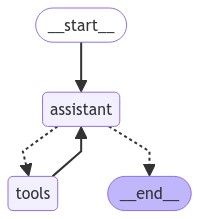

In [17]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import tools_condition
from typing import Annotated, List

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from langgraph.graph.message import AnyMessage, add_messages
from typing_extensions import TypedDict

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

class Assistant:
    def __init__(self, runnable: Runnable):
        """
        Initialize the Assistant with a runnable object.

        Args:
            runnable (Runnable): The runnable instance to invoke.
        """
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        """
        Call method to invoke the LLM and handle its responses.
        Re-prompt the assistant if the response is not a tool call or meaningful text.

        Args:
            state (State): The current state containing messages.
            config (RunnableConfig): The configuration for the runnable.

        Returns:
            dict: The final state containing the updated messages.
        """
        while True:
            result = self.runnable.invoke(state)  # Invoke the LLM
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def handle_tool_error(state: State) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


# Create the primary assistant prompt template
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant tasked with helping consultant assistants in their work or new Consultants in their tasks. "
            "You have access to tools specific for finding files before handling conformity matrix and drafting emails"
        ),
        ("placeholder", "{messages}"),
    ]
)
# Prompt our LLM and bind tools
assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)


#-----------------------------------
# Graph
builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
memory = MemorySaver()
pipe = builder.compile(checkpointer=memory)
# Show --------------------------------------------------
display(Image(pipe.get_graph(xray=True).draw_mermaid_png()))

In [18]:
import uuid
def answer(example: Dict[str, Any]):
    """Use this for answer evaluation"""
    
    initial_state = State(messages=[
        HumanMessage(content=example["input"])
    ])
    
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    
    final_state = None
    step_count = 0
    for output in pipe.stream(initial_state, config):
        step_count += 1
        print(f"\n--- Step {step_count} ---")
        print("Current output:")
        print(output)
        
        
        # Print messages separately for better readability
        if "messages" in output:
            print("\nMessages:")
            for msg in output["messages"]:
                print(f"Role: {msg.type}")
                print(f"Content: {msg.content}")
                if hasattr(msg, 'tool_calls') and msg.tool_calls:
                    print(f"Tool Calls: {msg.tool_calls}")
                print("---")
        
        if "__end__" in output:
            final_state = output["__end__"]
            break
    
    if final_state:
        print("\nFinal State:")
        print(final_state)
    else:
        print("\nWarning: The workflow did not reach a final state.")
        print("Last output:")
        print(output)
    
    return {
        "response": output["messages"][-1].content if "messages" in output else None,
        "messages": output.get("messages", []),
        "final_state": final_state
    }

# Example usage
example = {
    "input": "Let's analyze conformity matrix data from the file 'exhibit_01_drones.xlsx' and draft emails if necessary.",
}
response = answer(example)


--- Step 1 ---
Current output:
{'assistant': {'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-4ef4add4d3e346fa8522f40673c18bb0', 'type': 'function', 'function': {'name': 'analyze_conformity_matrix', 'arguments': '{"file_path": "exhibit_01_drones.xlsx"}'}}]}, response_metadata={'role': 'assistant', 'content': None, 'tool_calls': [{'id': 'chatcmpl-tool-4ef4add4d3e346fa8522f40673c18bb0', 'type': 'function', 'function': {'name': 'analyze_conformity_matrix', 'arguments': '{"file_path": "exhibit_01_drones.xlsx"}'}}], 'token_usage': {'prompt_tokens': 509, 'total_tokens': 543, 'completion_tokens': 34}, 'finish_reason': 'tool_calls', 'model_name': 'meta/llama-3.1-405b-instruct'}, id='run-fb3c1cc1-09e7-4951-ab1a-053cb75a3192-0', tool_calls=[{'name': 'analyze_conformity_matrix', 'args': {'file_path': 'exhibit_01_drones.xlsx'}, 'id': 'chatcmpl-tool-4ef4add4d3e346fa8522f40673c18bb0', 'type': 'tool_call'}], role='assistant')}}
Attempting to load file from: 

: 

See trace with llama3.1 here:

https://smith.langchain.com/public/44d0c7dd-a756-47ad-8025-ee7ae6469ecb/r

In [ ]:
example = {"input": "Get me information about the current weather in SF."}
response = predict_react_agent_answer(example)